### PuLP

Objective Value: 105.0


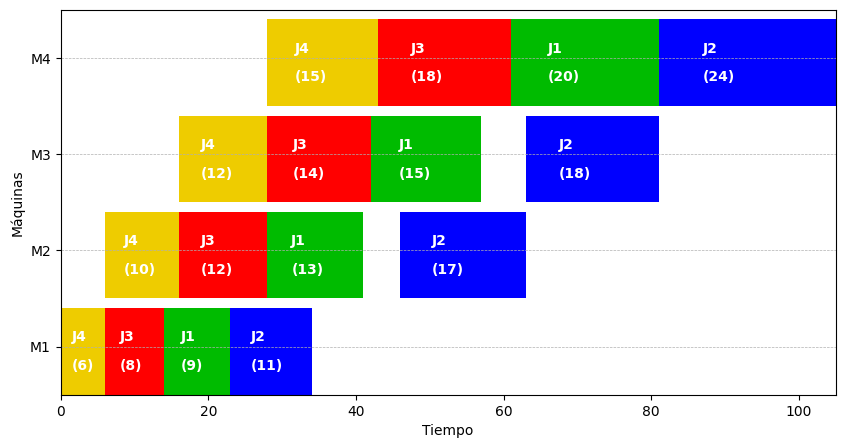

In [4]:
import pulp as lp
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
            [11, 17, 18, 24],
            [8, 12, 14, 18],
            [6, 10, 12, 15]])
T = T.transpose()

# Create the LP problem
model = lp.LpProblem("The_Wilson_Model", lp.LpMinimize)

# Define the decision variables
N = len(T[0])  # Number of jobs
M = len(T)     # Number of machines

Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
B = lp.LpVariable.dicts("B", (range(N), range(M)), lowBound=0, cat='Integer')

# Define the objective function
model += B[M-1][N-1] + lp.lpSum(T[M-1][i] * Z[i][N-1] for i in range(N))


# Define the constraints
#(6)
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
#(7)
for j in range(N):
    model += lp.lpSum(Z[i][j] for i in range(N)) == 1

#(8)
for j in range(N-1):
    model += B[0][j] + lp.lpSum(T[0][i] * Z[i][j] for i in range(N)) == B[0][j+1]

#(9)
model += B[0][0] == 0

#(10)
for r in range(M-1):
    model += (B[r][0] + lp.lpSum(T[r][i] * Z[i][0] for i in range(N)) == B[r+1][0])

#(11)
for r in range(M-1):
    for j in range(1,N):
        model += (B[r][j] + lp.lpSum(T[r][i] * Z[i][j] for i in range(N)) <= B[r+1][j])
        
#(12)
for r in range(1,M):
    for j in range(N-1):
        model += (B[r][j] + lp.lpSum(T[r][i] * Z[i][j] for i in range(N)) <= B[r][j+1])

# Solve the LP problem
solution = model.solve()

# Print the optimal solution
print("Objective Value:", lp.value(model.objective))

# Carta Gannt
import matplotlib.pyplot as plt

unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        maquina.append([int(B[r][j].varValue), int(B[r][j].varValue) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

### CPLEX

Objective Value: 105.0


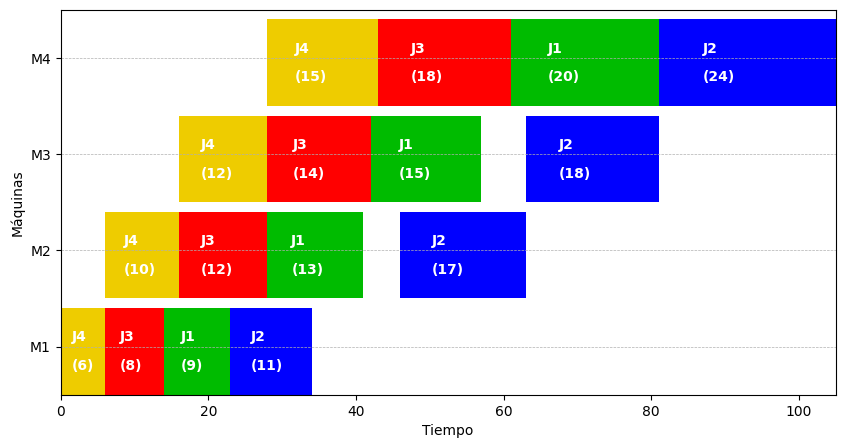

In [5]:
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()

# Create the model
model = Model(name="The_Wilson_Model")

# Define the decision variables
N = len(T[0])  # Number of jobs
M = len(T)     # Number of machines

Z = {(i, j): model.binary_var(name=f"Z_{i}_{j}") for i in range(N) for j in range(N)}
B = {(i, j): model.integer_var(lb=0, name=f"B_{i}_{j}") for i in range(M) for j in range(N)}

# Define the objective function
model.minimize(B[M-1,N-1] + model.sum(T[M-1][i] * Z[i,N-1] for i in range(N)))

# Define the constraints
#(6)
for i in range(N):
    model.add_constraint(model.sum(Z[i,j] for j in range(N)) == 1)

#(7)
for j in range(N):
    model.add_constraint(model.sum(Z[i,j] for i in range(N)) == 1)

#(8)
for j in range(N-1):
    model.add_constraint(B[0,j] + model.sum(T[0,i] * Z[i,j] for i in range(N)) == B[0,j+1])

#(9)
model.add_constraint(B[0,0] == 0)

#(10)
for r in range(M-1):
    model.add_constraint(B[r, 0] + model.sum(T[r][i] * Z[i,0] for i in range(N)) == B[r+1, 0])

#(11)
for r in range(M-1):
    for j in range(1, N):
        model.add_constraint(B[r, j] + model.sum(T[r, i] * Z[i, j] for i in range(N)) <= B[r+1, j])

#(12)
for r in range(1, M):
    for j in range(N-1):
        model.add_constraint(B[r,j] + model.sum(T[r,i] * Z[i,j] for i in range(N)) <= B[r,j+1])

# Solve the model
model.solve()

# Print the optimal solution
print("Objective Value:", model.objective_value)

# Carta Gannt
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i, j].solution_value == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        maquina.append([int(B[r, j].solution_value), int(B[r, j].solution_value) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model.objective_value)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

### Gurobi

Objective Value: 105.0
[3, 2, 0, 1]


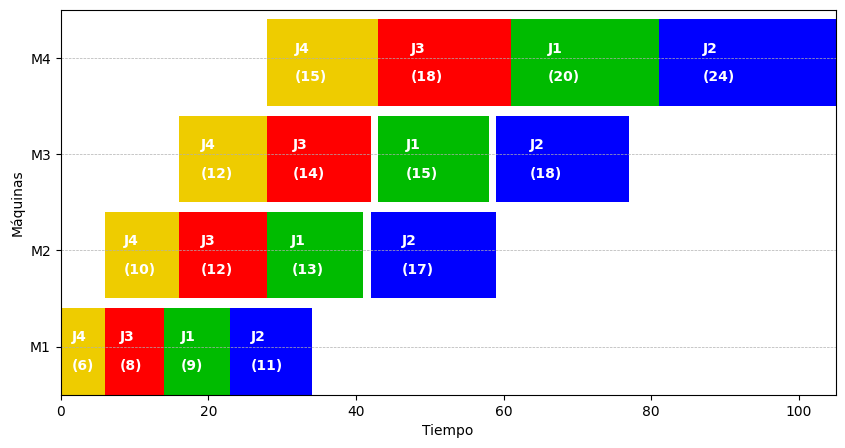

In [6]:
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()

# Create the model
model = gp.Model("The_Wilson_Model")

# Define the decision variables
N = len(T[0])  # Number of jobs
M = len(T)     # Number of machines

Z = model.addVars(N, N, vtype=GRB.BINARY, name="Z")
B = model.addVars(M, N, lb=0, vtype=GRB.INTEGER, name="B")

# Define the objective function
model.setObjective(B[M-1, N-1] + gp.quicksum(T[M-1, i] * Z[i, N-1] for i in range(N)), GRB.MINIMIZE)

# Define the constraints
#(6)
for i in range(N):
    model.addConstr(gp.quicksum(Z[i,j] for j in range(N))== 1)

#(7)
for j in range(N):
    model.addConstr(gp.quicksum(Z[i,j] for i in range(N))== 1)

#(8)
for j in range(N-1):
    model.addConstr(B[0, j] + gp.quicksum(T[0, i] * Z[i, j] for i in range(N)) == B[0, j+1])

#(9)
model.addConstr(B[0, 0] == 0)

#(10)
for r in range(M-1):
    model.addConstr(B[r, 0] + gp.quicksum(T[r, i] * Z[i, 0] for i in range(N)) == B[r+1, 0])

#(11)
for r in range(M-1):
    for j in range(1, N):
        model.addConstr(B[r, j] + gp.quicksum(T[r, i] * Z[i, j] for i in range(N)) <= B[r+1, j])

#(12)
for r in range(1, M):
    for j in range(N-1):
        model.addConstr(B[r, j] + gp.quicksum(T[r, i] * Z[i, j] for i in range(N)) <= B[r, j+1])

# Solve the model
model.setParam('OutputFlag', False)
model.optimize()

# Print the optimal solution
print("Objective Value:", model.objVal)

unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i, j].x == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

print (orden_tareas)
matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        maquina.append([int(B[r, j].x), int(B[r, j].x) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

# Graficar la carta de Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model.objVal)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')